# Introduction to Pathogen.jl

## Initialization

We start by loading Pathogen.jl in julia

In [1]:
using Pathogen

Additionally we'll use: 
* DataFrames.jl for individual level information
* Distributions.jl for random generation of individual level information
* Plot.jl for visualization (using whichever visualization backend your prefer)

In [2]:
using DataFrames, Distributions, Plots

## Simulation
We'll set the seed for random number generation such that our results here are reproducible:

In [3]:
srand(5432)

MersenneTwister(UInt32[0x00001538], Base.dSFMT.DSFMT_state(Int32[-1744756614, 1072761743, -2028083806, 1073624598, -581637934, 1073626379, 327696063, 1073382742, 738168642, 1073600735  …  -595993142, 1072726157, 913087430, 1073114622, 2001550298, -624279679, 872770575, 1763491762, 382, 0]), [1.63776, 1.73172, 1.18556, 1.33645, 1.17948, 1.86669, 1.57172, 1.55745, 1.76821, 1.48793  …  1.77676, 1.55126, 1.97279, 1.27443, 1.27899, 1.7781, 1.52741, 1.91565, 1.47632, 1.36497], 382)

We'll define a population consisting of *n* individuals, uniformaly distributed over a 10x10 unit area. For our population we'll assume to have information on a single risk factor, which we'll distribute following a Gamma(1,1) distribution.

In [4]:
n = 250
x_coordinates = rand(Uniform(0, 10), n)
y_coordinates = rand(Uniform(0, 10), n)
riskfactor1 = rand(Gamma(), n)

250-element Array{Float64,1}:
 0.316139 
 1.58715  
 2.01711  
 0.769778 
 4.86302  
 0.513204 
 2.00259  
 1.28672  
 0.617716 
 1.06868  
 1.11697  
 4.37915  
 1.79654  
 ⋮        
 0.11919  
 0.614955 
 2.6781   
 0.0718771
 0.288097 
 0.572776 
 0.176569 
 1.39745  
 2.77806  
 0.998993 
 0.154508 
 0.403527 

With Pathogen.jl, `DataFrame`s are used for individual information. We'll organize location and risk factor information into one before proceeding with epidemic simulation. The row number in this dataframe is the individual's ID.

In [5]:
pop = DataFrame(x = x_coordinates,
                y = y_coordinates,
                riskfactor1 = riskfactor1)

,x,y,riskfactor1
1,0.457796,7.70517,0.316139
2,1.58149,1.31192,1.58715
3,2.77421,9.65545,2.01711
4,2.8265,6.48518,0.769778
5,9.30925,7.64767,4.86302
6,0.745385,1.31865,0.513204
7,5.51862,3.38113,2.00259
8,6.65555,8.77079,1.28672
9,3.8933,8.53216,0.617716
10,4.97396,5.80774,1.06868


Pathogen.jl supports SEIR, SEI, SIR, and SI individual level models. Within each of those model types, the user has full control over the functions describing individual specific transition rates between disease states (*i.e.* form of, and relevant risk factors to, susceptibility, infectivity, transmissability, latency, removal, and sparks functions when applicable). For ease of use, some common forms of these functions are provided in `examples/risk_functions.jl` which can either be loaded and used directly, or serve as examples to help the user construct their own. For this example we will use some of these functions directly in an SEIR individual level model. 

In [6]:
include(Pkg.dir("Pathogen")*"/examples/risk_functions.jl")

rf = RiskFunctions{SEIR}(_constant, # sparks function
                         _coefficient, # susceptibility function
                         _powerlaw, # transmissability function
                         _one, # infectivity function
                         _constant, # latency function
                         _constant) # removal function

Pathogen.SEIR model risk functions

Each of these functions is parameterized by a `Vector{Float64}`...

In [7]:
rparams = RiskParameters{SEIR}([0.001], # sparks function parameter(s)
                               [1.0], # susceptibility function parameter(s)
                               [1.0, 6.0], # transmissibility function parameter(s)
                               Float64[], # infectivity function parameter(s)
                               [0.1], # latency function parameter(s)
                               [0.05]) # removal function parameter(s)

Pathogen.SEIR model risk function parameters

We initialize an Epidemic `Simulation` object by supplying the population `DataFrame` with our individual level model risk functions and their associated parametrizations.

In [8]:
sim = Simulation(pop, rf, rparams)

Pathogen.Simulation{Pathogen.SEIR}(0.0, 0, 250×3 DataFrames.DataFrame
│ Row │ x        │ y       │ riskfactor1 │
├─────┼──────────┼─────────┼─────────────┤
│ 1   │ 0.457796 │ 7.70517 │ 0.316139    │
│ 2   │ 1.58149  │ 1.31192 │ 1.58715     │
│ 3   │ 2.77421  │ 9.65545 │ 2.01711     │
│ 4   │ 2.8265   │ 6.48518 │ 0.769778    │
│ 5   │ 9.30925  │ 7.64767 │ 4.86302     │
│ 6   │ 0.745385 │ 1.31865 │ 0.513204    │
│ 7   │ 5.51862  │ 3.38113 │ 2.00259     │
│ 8   │ 6.65555  │ 8.77079 │ 1.28672     │
│ 9   │ 3.8933   │ 8.53216 │ 0.617716    │
│ 10  │ 4.97396  │ 5.80774 │ 1.06868     │
│ 11  │ 7.92295  │ 6.99372 │ 1.11697     │
⋮
│ 239 │ 6.71937  │ 0.71781 │ 0.11919     │
│ 240 │ 3.31195  │ 5.00324 │ 0.614955    │
│ 241 │ 6.47489  │ 1.21015 │ 2.6781      │
│ 242 │ 8.64379  │ 8.45115 │ 0.0718771   │
│ 243 │ 2.46181  │ 3.86811 │ 0.288097    │
│ 244 │ 6.96766  │ 7.58439 │ 0.572776    │
│ 245 │ 2.28163  │ 5.83381 │ 0.176569    │
│ 246 │ 5.87731  │ 2.68674 │ 1.39745     │
│ 247 │ 6.07869  │ 3.8342

This simulation can now be ran until either a specified stop condition is met (computation time, simulation time, or a maximum number of iterations), or until there are no further possible events.

In [9]:
simulate!(sim, tmax=100.0)

Simulating until: 
* a simulation time maximum of 100.0,
* an iteration maximum of 1000, or,
* a processing time maximum of Inf seconds.

Simulation stopped: simulation time maximum reached


Pathogen.Simulation{Pathogen.SEIR}(100.62263966976397, 741, 250×3 DataFrames.DataFrame
│ Row │ x        │ y       │ riskfactor1 │
├─────┼──────────┼─────────┼─────────────┤
│ 1   │ 0.457796 │ 7.70517 │ 0.316139    │
│ 2   │ 1.58149  │ 1.31192 │ 1.58715     │
│ 3   │ 2.77421  │ 9.65545 │ 2.01711     │
│ 4   │ 2.8265   │ 6.48518 │ 0.769778    │
│ 5   │ 9.30925  │ 7.64767 │ 4.86302     │
│ 6   │ 0.745385 │ 1.31865 │ 0.513204    │
│ 7   │ 5.51862  │ 3.38113 │ 2.00259     │
│ 8   │ 6.65555  │ 8.77079 │ 1.28672     │
│ 9   │ 3.8933   │ 8.53216 │ 0.617716    │
│ 10  │ 4.97396  │ 5.80774 │ 1.06868     │
│ 11  │ 7.92295  │ 6.99372 │ 1.11697     │
⋮
│ 239 │ 6.71937  │ 0.71781 │ 0.11919     │
│ 240 │ 3.31195  │ 5.00324 │ 0.614955    │
│ 241 │ 6.47489  │ 1.21015 │ 2.6781      │
│ 242 │ 8.64379  │ 8.45115 │ 0.0718771   │
│ 243 │ 2.46181  │ 3.86811 │ 0.288097    │
│ 244 │ 6.96766  │ 7.58439 │ 0.572776    │
│ 245 │ 2.28163  │ 5.83381 │ 0.176569    │
│ 246 │ 5.87731  │ 2.68674 │ 1.39745     │
│ 247 │ 

### Visualization
Using our preferred plotting backend we can produce several informative plots for a simulated epidemic...

In [10]:
gr()

Plots.GRBackend()

a `plot()` method is provided for `Events` objects - such as those generated within a simulation. This will create an epidemic plot.

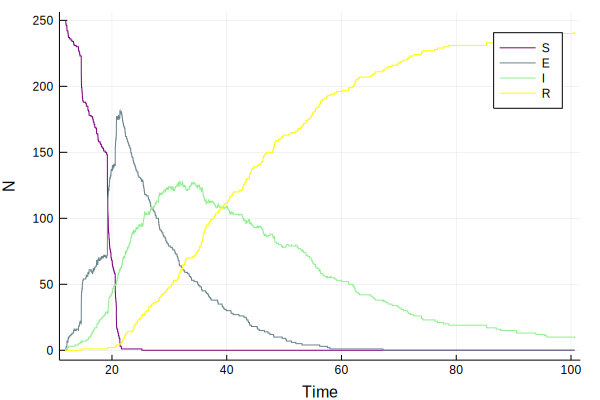

In [11]:
plot(sim.events)

We can also visualize transmission networks through time - below is an animation showing the spread of an epidemic for the first 50 time units.

In [13]:
epidemic_animation = @animate for t in linspace(10., 25., 100) # From t = 10.0 to t= 20.0 with 100 increments
    plot(sim.transmission_network, sim.population, sim.events, t)
end
mp4(epidemic_animation, Pkg.dir("Pathogen")*"/examples/01_epidemic_animation.mp4", fps=10)

INFO: Saved animation to /Users/justin/.julia/v0.6/Pathogen/examples/01_epidemic_animation.mp4


Plots.AnimatedGif("/Users/justin/.julia/v0.6/Pathogen/examples/01_epidemic_animation.mp4")